# Тема: Принятие решений в бизнесе
# Проект: Проверка гипотез по увеличению выручки в интернет-магазине

**Задача:**
Оценить результаты A/B-теста проведенного в крупном интернет-магазине.


**Цели:**
* Приоритизировать гипотезы; 
* Запустить A/B-тест; 
* Проанализировать результаты.



**Описание данных**


Файл `/datasets/hypothesis.csv.`

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.



Файл `/datasets/orders.csv.`
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.


Файл `/datasets/visitors.csv.`
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка к анализу

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
# сбросим ограничения на вывод табличных данных. 
# ширину столбцов оставим без ограничений для удобства прочтения текста в ячейках
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
# cнизим размерность чисел для вывода на экран во всем проекте
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# сохраним данные в переменных
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('/datasets/orders.csv'),      # заказы
    pd.read_csv('/datasets/visitors.csv')     # пользователи
)

Получим общую информацию о данных в таблицах `hypothesis`, `orders` и `visitors`. Убедимся, что тип данных в каждой колонке верный. Изучим содержимое строк и проверим данные на наличие дубликатов.

### Таблица 'hypothesi'

In [5]:
# получим общую информацию о данных
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
# изучим содержимое строк
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице `hypothesis` строчные буквы сочетаются с прописными. Приведем названия столбцов к нижнему регистру.

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

In [8]:
# проверим произошли ли изменения
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Проверку на дубликаты производить не будем. В таблице перечень гипотез по увеличению выручки интернет-магазина.

### Таблица 'orders'

In [9]:
# получим общую информацию о данных
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
# изучим содержимое первых 10 строк таблицы
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


* Расхождения с хорошим стилем в названиях колонок `transactionId` и `visitorId`. Строчные буквы сочетаются с прописными и не соблюдается змеиный регистр; 
* В столбце `date` необходимо изменить тип данных. Поменяем **object** на **datetime64**.

In [11]:
# переименовываем столбцы
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)

In [12]:
# проверим произошли ли изменения
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [13]:
# корректируем тип данных
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
# проверим изменения
orders.dtypes

transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

Проверим пересечение пользователей в группах А и В.

In [15]:
# вычислим количество уникальных пользователей
len(orders['visitor_id'].unique())

1031

Построим сводную таблицу объединив данные по уникальным visitor_id.

In [16]:
non_unique_users = orders.pivot_table(index = 'visitor_id', values = 'group', aggfunc = 'nunique').reset_index()

In [17]:
non_unique_users.head()

,visitor_id,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


In [18]:
# подсчитаем количество пересекающихся пользователей
non_unique_users.query('group > 1').count()

visitor_id    58
group         58
dtype: int64

Отфильтруем пересекающихся пользователей для того чтобы не искажать результаты теста.

In [19]:
# сохраним id  пересекающихся пользователей в отдельной переменной
data_to_delete = non_unique_users.query('group > 1')
data_to_delete = data_to_delete['visitor_id']

len(data_to_delete)

58

In [20]:
# сохраним отфильтрованные данные в прежней переменной
orders = orders[orders.visitor_id.isin(data_to_delete) == False]

In [21]:
# проверим работу фильтра
len(orders['visitor_id'].unique())

973

Посчитаем количество явных дубликатов в таблице.

In [22]:
orders.duplicated().sum()

0

### Таблица 'visitors'

In [23]:
# получим общую информацию о данных
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [24]:
# изучим содержимое первых 10 строк таблицы
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [25]:
# изменим тип данных в столбце date с object на datetime64.
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [26]:
# проверим изменения
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

Посчитаем количество явных дубликатов в таблице.

In [27]:
visitors.duplicated().sum()

0

### Выводы

* Пропуски и явные дубликаты не выявлены;
* Названия колонок в таблицах `hypothesis` и `orders` приведены к нижнему регистру и змеиному стилю;
* В таблице `orders` выявлены и удалены пользователи встречающиеся в обеих группах одновременно;
* Изменен формат значений в колонке 'date' в таблицах `orders` и `visitors`(с object на datetime64).

## Приоритизация гипотез

В таблице `hypothesis` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

Задачи:
* Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

Для большего понимания результатов по итогам применения методов упорядочивания экспериментов выведем таблицу `hypothesis`.

In [28]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Посчитаем ICE для гипотез. Добавим полученные значения ICE к существующей таблице. Новый столбец назовем ICE.

In [29]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [30]:
# отсортируем данные по убыванию приоритета
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE в строках 8, 0, 7 :
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Посчитаем RICE для гипотез. Добавим полученные значения RICE к существующей таблице. Новый столбец назовем RICE.

In [31]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [32]:
# отсортируем данные по убыванию приоритета
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Наиболее перспективные гипотезы по RICE в строках 7, 2, 0, 6:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Теперь гипотеза со строки 7 заняла первую позицию, так как ее значение Reach - 10. Это самое большое значение среди всех гипотез. Гипотеза со строчки 2 на втором месте. Этому также поспособствовал высокий показатель Reach - 8. Это второе по величине значение. У гипотезы со строки 0 показатель Reach - 3, но оставшиеся показатели impact(10), confidence(8) и efforts(6) достаточно высокие.

### Выводы

* Для приоритизации гипотез были применены фреймворки ICE и RICE.
* Наиболее перспективная гипотеза по ICE - Запустить акцию, дающую скидку на товар в день рождения;
* Наиболее перспективная гипотеза по RICE - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок; Причина изменения приоритизации гипотез при применении RICE - максимальное значение Reach (10 баллов).

## Анализ A/B-теста

Был проведен A/B-тест и получены результаты, которые описаны в таблицах `orders` и `visitors`.

Задачи:

Проанализировать A/B-тест:
  * Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
  * Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
  * Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
  * Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
  * Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
  * Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
  * Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
  * Построить точечный график стоимостей заказов. Сделать выводы и предположения.
  * Посчитать 95-й и 99-й перцентили стоимости заказов. Выберать границу для определения аномальных заказов.
  * Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
  * Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
  * Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
  * Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
  * Принять решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

### Кумулятивные метрики

#### Кумулятивная выручка по группам

Создадим датафрейм dates_groups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates().

In [33]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [34]:
# получаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])].agg({'date' : 'max', 
                                                                                                          'group' : 'max', 
                                                                                                          'transaction_id' : 'nunique', 
                                                                                                          'visitor_id' : 'nunique', 
                                                                                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date', 'group'])

In [35]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [36]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])].agg({'date' : 'max', 
                                                                                                                'group' : 'max', 
                                                                                                                'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [37]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [38]:
# выведем получившийся результат
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

In [39]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням 
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']] # в группе А
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']] # в группе B

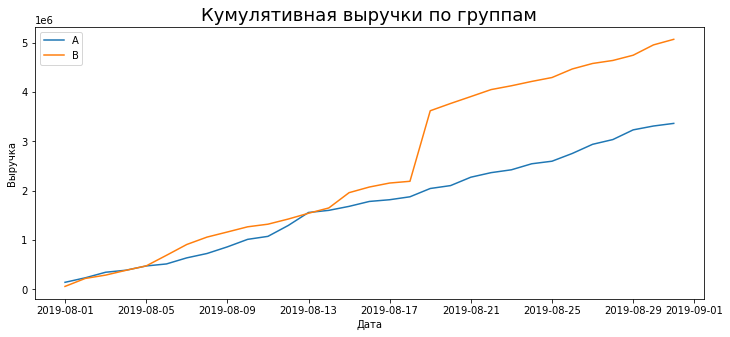

In [40]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# строим график выручки группы А и В
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# подпишем график и оси
plt.title('Кумулятивная выручки по группам', fontsize=18)
plt.xlabel('Дата'), plt.ylabel('Выручка')

plt.legend()

plt.show()

В обеих группах выручка почти равномерно увеличивается в течение всего теста. На графике группы `В` в точке от 19.08.19 заметен резкий рост. На графике группы `А` тоже есть скачки, но менее выраженные. Самый большой от 13.08.19.

Возможно это всплеск числа заказов, либо появление очень дорогих заказов в выборке.

#### Кумулятивный средний чек по группам

Построим графики среднего чека по группам.

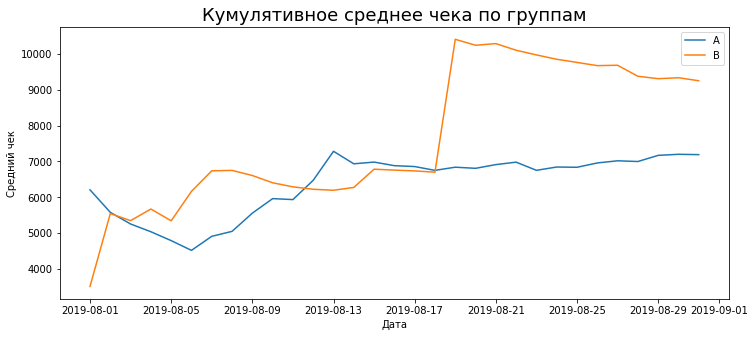

In [41]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

# подпишем график и оси
plt.title('Кумулятивное среднее чека по группам', fontsize=18)
plt.xlabel('Дата'), plt.ylabel('Средний чек')

plt.legend()

plt.show()

Кумулятивное значение среднего чека колеблется. Графики пересекаются в нескольких местах. После 18.08.19 график группы В резко идет вверх. Нам понадобится доп. анализ выбросов, которые так сильно искажают результат.

#### Относительное изменение кумулятивного среднего чека группы B к группе A

Перед тем как построить график объединим таблицы `cumulative_revenue_a` и `cumulative_revenue_b`. Сохраним их в переменной `merged_cumulative_revenue`.

In [42]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [43]:
# проверим, удалось ли нам корректно объединить данные
merged_cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


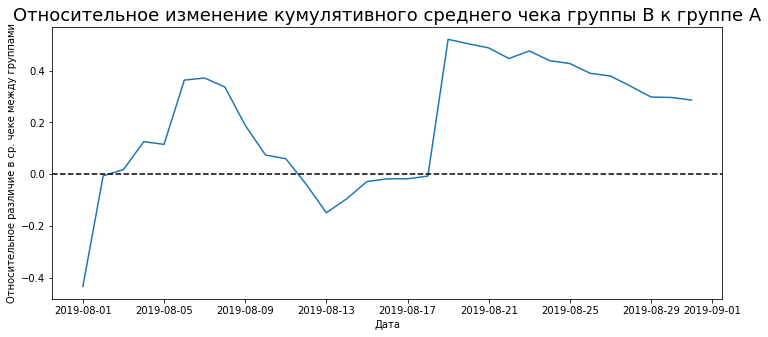

In [44]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем пунктирную линию
plt.axhline(y=0, color='black', linestyle='--')

# подпишем график и оси
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', fontsize=18)
plt.xlabel('Дата'), plt.ylabel('Относительное различие в ср. чеке между группами')

plt.show()

Результаты теста резко меняются в несколько дат. Видимо в эти даты были совершены аномальные заказы.

#### Кумулятивная конверсия по группам

Добавим в `cumulative_data` столбец 'conversion' c отношением числа заказов к количеству пользователей в указанной группе в указанный день. Объявим переменные `cumulative_data_a` и `cumulative_data_b`, в которых сохраним данные о заказах в сегментах A и B.

In [45]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [46]:
# отделяем данные по группам
cumulative_data_a = cumulative_data[cumulative_data['group']=='A'] # группа А
cumulative_data_b = cumulative_data[cumulative_data['group']=='B'] # группа В

Изменим масштаб графика чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое. Для этого определим границы графика.

In [47]:
cumulative_data['date'].min(), cumulative_data['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

In [48]:
cumulative_data['conversion'].describe()

count   62.00
mean     0.03
std      0.00
min      0.02
25%      0.03
50%      0.03
75%      0.03
max      0.04
Name: conversion, dtype: float64

Приступим к построению графиков кумулятивной конверсии по группам.

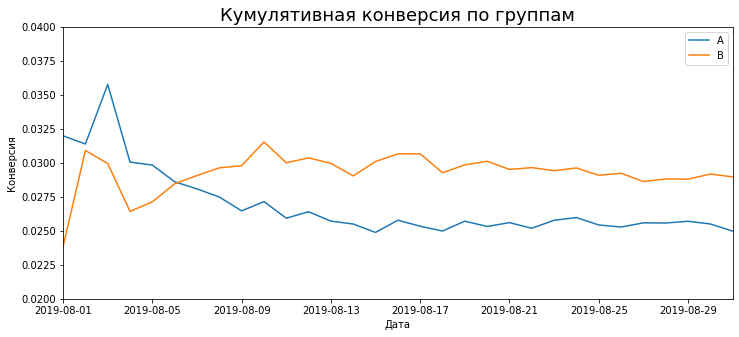

In [49]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.02, 0.04])

# подпишем график и оси
plt.title('Кумулятивная конверсия по группам', fontsize=18)
plt.xlabel('Дата'), plt.ylabel('Конверсия')

plt.show()

В начале теста конверсия группы `А` была выше конверсии группы `В`. Начиная с 06.08.19 показатели группы `А` просели, а `В` возросли. К концу графика значения обеих групп выровнялись и зафиксировались.

#### Относительное изменение кумулятивной конверсии группы B к группе A

Объединим таблицы cumulative_data_a и cumulative_data_b сохранив их в переменной merged_cumulative_conversions.

In [50]:
merged_cumulative_conversions = cumulative_data_a[['date', 
                                                   'conversion']].merge(cumulative_data_b[['date', 'conversion']], 
                                                                        left_on='date', 
                                                                        right_on='date', 
                                                                        how='left', 
                                                                        suffixes=['A', 'B'])

In [51]:
# проверим как объединились данные
merged_cumulative_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.03,0.02
1,2019-08-02,0.03,0.03
2,2019-08-03,0.04,0.03
3,2019-08-04,0.03,0.03
4,2019-08-05,0.03,0.03


Построим график относительного различия кумулятивной конверсии группы B к группе A. Добавим в него пунктирную линию оси X со значением оси Y = 0 методом plt.axhline(). И ещё одну линию оси X серого цвета со значением оси Y = 0.15.

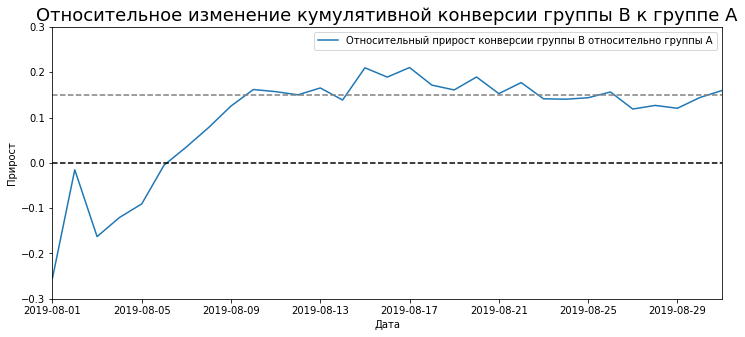

In [52]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# строим графики
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

# добавляем пунктирные линии
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.3, 0.3])

# подпишем график и оси
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A', fontsize=18)
plt.xlabel('Дата'), plt.ylabel('Прирост')

plt.show()

Конверсия группы `В` в начале теста несколько раз падала. Начиная с 05.08.19 медленно поползла вверх. К концу теста остановилась около прироста в 15% относительно группы `А`.


В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

### Анализ выбросов и всплесков

#### Количество заказов по пользователям

Подсчитаем количество заказов по пользователям. Сгруппируем данные по колонке 'visitor_id'.

In [53]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

In [54]:
# переименуем колонки
orders_by_users.columns = ['visitor_id', 'orders']

In [55]:
# отсортируем кол-во заказов по убыванию
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Посмотрим на их распределение на одного пользователя. Построим гистограмму.

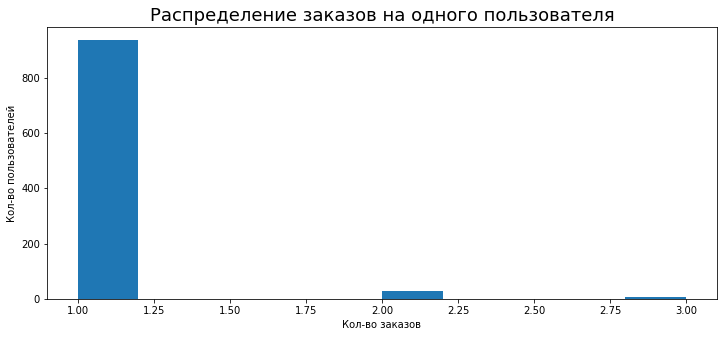

In [56]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# построим гистограмму
plt.hist(orders_by_users['orders'])

# подпишем график и оси
plt.title('Распределение заказов на одного пользователя', fontsize=18)
plt.xlabel('Кол-во заказов'), plt.ylabel('Кол-во пользователей')

plt.show()

Большинство покупателей заказывали только один раз. Доля остальных пользователей незначительна.

Построим точечную диаграмму числа заказов на одного пользователя.

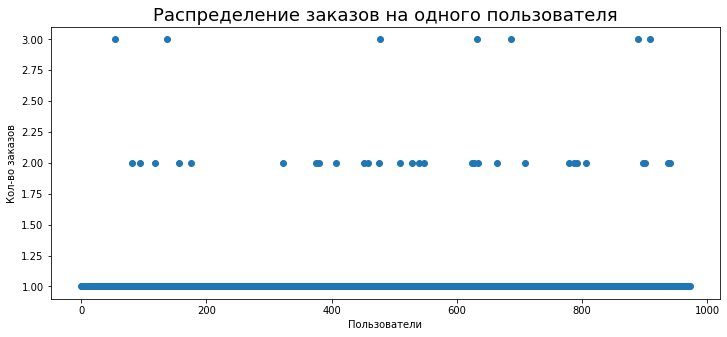

In [57]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))


x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])

# подпишем график и оси
plt.title('Распределение заказов на одного пользователя', fontsize=18)
plt.xlabel('Пользователи'), plt.ylabel('Кол-во заказов')

plt.show()

Диаграмма подтверждает что пользователей с 2-3 заказами немного. Непонятно какая у них доля и поэтому неясно нужно ли их считать аномалиями или нет.

#### Граница для определения аномальных пользователей

Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [58]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше чем 1 заказа. 1% пользователей заказывали более 2-х раз. Возьмем за **нижнюю границу числа заказов** значение **2** и в дальнейшем отсеем аномальных пользователей по ней.

#### Cтоимость заказов

Изучим гистограмму распределения стоимостей заказов.

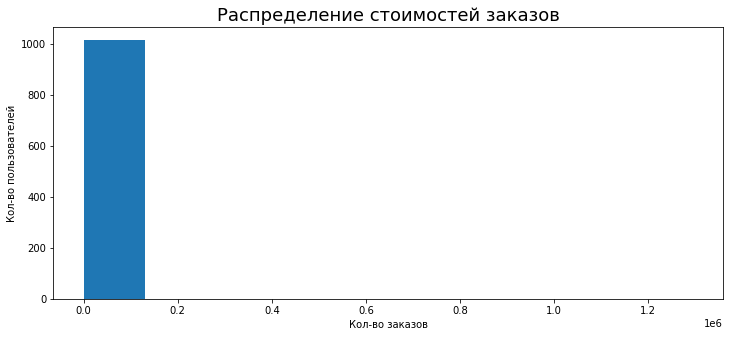

In [59]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

# построим гистограмму
plt.hist(orders['revenue'])

# подпишем график и оси
plt.title('Распределение стоимостей заказов', fontsize=18)
plt.xlabel('Кол-во заказов'), plt.ylabel('Кол-во пользователей')

plt.show()

Большинство заказов имеет невысокую стоимость. Для того чтобы рассмотреть данные подробнее, построим точечную диаграмму.

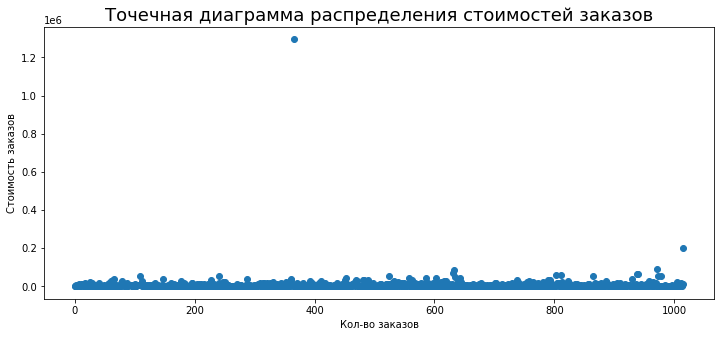

In [60]:
# зададим масштаб графика
plt.figure(figsize=(12, 5))

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

# подпишем график и оси
plt.title('Точечная диаграмма распределения стоимостей заказов', fontsize=18)
plt.xlabel('Кол-во заказов'), plt.ylabel('Стоимость заказов')

plt.show()

На диаграмме видны два больших заказа, которые выделяются из числа остальных. 
Первый на сумму более чем 1,3 млн, а второй на 200т. Посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу после которой величина заказов будет считаться аномальной.

#### Граница для определения аномальных заказов

In [61]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Нижней границей стоимости заказов назначим значение равное 26 785 рублей.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. Подготовка данных

Ранее мы:
* оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы;
* увидели выбросы и нашли границу для их определения.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Начнем с подготовки данных. Определим количество пользователей группы А в день. Сохраним данные в переменную `visitors_a_daily` и выведем получившуюся таблицу.

In [62]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

In [63]:
# переименуем столбцы
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

In [64]:
visitors_a_daily.head()

,date,visitors_per_date_a
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


Теперь определим кумулятивное количество пользователей группы А в день.

In [65]:
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)

In [66]:
# переименуем столбцы
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

In [67]:
# выведем первые 5 строк таблицы
visitors_a_cummulative.head()

,date,visitors_cummulative_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


Проделаем те же шаги с пользователями из группы В. Определим их количество в день. Сохраним данные в переменную `visitors_b_daily.` 

In [68]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [69]:
# переименуем столбцы
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

In [70]:
# выведем первые 5 строк таблицы
visitors_b_daily.head()

,date,visitors_per_date_b
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


Найдем кумулятивное количество пользователей группы В в день.

In [71]:
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)

In [72]:
# переименуем столбцы
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

In [73]:
# выведем первые 5 строк таблицы
visitors_b_cummulative.head()

,date,visitors_cummulative_b
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


Определим количество заказов и суммарную выручку группы А в день

In [74]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

In [75]:
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

In [76]:
orders_a_daily.head()

,date,orders_per_date_a,revenue_per_date_a
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


Определим кумулятивное количество заказов и суммарную выручку группы А в день.

In [77]:
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [78]:
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

In [79]:
orders_a_cummulative.head()

,date,orders_cummulative_a,revenue_cummulative_a
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


Определим количество заказов и суммарную выручку группы B в день.

In [80]:
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

In [81]:
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [82]:
orders_b_daily.head()

,date,orders_per_date_b,revenue_per_date_b
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


Определим кумулятивное количество заказов и суммарную выручку группы В в день.

In [83]:
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [84]:
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

In [85]:
orders_b_cummulative.head()

,date,orders_cummulative_b,revenue_cummulative_b
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


Полученные данные объединим в одну таблицу.

In [86]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

Проверим результат объединения таблиц.

In [87]:
data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами. Создадим переменные `orders_by_users_a` и `orders_by_users_b`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [88]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

In [89]:
orders_by_users_a.columns = ['visitor_id', 'orders']

In [90]:
orders_by_users_a.head()

,visitor_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [91]:
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

In [92]:
orders_by_users_b.columns = ['visitor_id', 'orders']

In [93]:
orders_by_users_b.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [94]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [95]:
sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы:
* Нулевая (**Н0**) -  `различий в конверсии между группами нет;` 
* Альтернативная (**H1**) - `различия в конверсии между группами есть.`

Выведем p-value для сравнения конверсии между группами. Округлим его значение до 3 знаков после запятой. Установим критический уровень статистической значимости на отметке 0.05. С ним будем сравнивать наш результат.

In [96]:
"{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1])

'0.011'

P-value значительно меньше 0.05. Отвергаем нулевую гипотезу. Анализ 'сырых данных' показал, что в конверсии между группами есть статистически значимые различия.

Вычислим и выведем относительное различие в конверсии между группами. Округлим значение до 3 знаков после запятой.

In [97]:
"{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1)

'0.160'

Относительный прирост конверсии группы `В` к конверсии группы `А` равен 16%.

Проверим статистическую значимость различий в среднем чеке между сегментами. 

Сформулируем гипотезы:
* Нулевая (**Н0**) - `различий в среднем чеке между группами нет;`
* Альтернативная (**H1**) - `различия в среднем чеке между группами есть.`

Найдем p-value для сравнения средних чеков между группами. Округлим значение до трёх знаков после запятой. Установим критический уровень статистической значимости на отметке 0.05.

In [98]:
# передадим критерию mannwhitneyu() данные о выручке с заказов
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

'0.829'

P-value больше чем установленное нами значение критического уровня статистической значимости. Не получилось отвергнуть нулевую гипотезу. Статистически значимых отличий в среднем чеке между группами нет.

Выведем относительный прирост среднего чека группы B, округлив до трёх знаков после запятой.

In [99]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.287'

Относительное различие среднего чека между сегментами ~29%. Наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

В предыдущих пунктах (3.2.2, 3.2.4) были найдены следующие значения:
* 95-й и 99-й перцентили средних чеков - 26 785 и 53 904 рублей; 
* 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказам на пользователя.

Примем за аномальных пользователей тех, кто совершил 2 заказа и более или совершил заказ дороже 26 785 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и порядка 5% пользователей с дорогими заказами. 

In [100]:
# сохраним значение 99-го перцентиля количества заказов в переменной percentile_orders
percentile_orders = np.percentile(orders_by_users['orders'], 99)

# формируем срез количества заказов
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > percentile_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > percentile_orders]['visitor_id'],
    ],
    axis=0,
)

In [101]:
# проверим работу фильтра
users_with_many_orders.head()

58      611059232
211    2108163459
310    2988190573
409    3908431265
416    3967698036
Name: visitor_id, dtype: int64

In [102]:
# сохраним значение 95-го перцентиля средних чеков в переменной percentile_revenue
percentile_revenue = np.percentile(orders['revenue'], 95)

# формируем срез средних чеков
users_with_expensive_orders = orders[orders['revenue'] > percentile_revenue]['visitor_id']

In [103]:
# проверим работу фильтра
users_with_expensive_orders.head()

73     2947100995
77      787824685
78     3288820196
131    2254586615
137    1211585711
Name: visitor_id, dtype: int64

Узнаем количество аномальных пользователей. 

In [104]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [105]:
abnormal_users.shape[0]

58

Всего 58 аномальных пользователя. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [106]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [107]:
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Определим гипотезы:
* Нулевая (**H0**) - `различий в конверсии между группами нет;`
* Альтернативная (**H1**) - `различия в конверсии между группами есть.`


К полученным выборкам применим статистический критерий Манна-Уитни.

In [108]:
'{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1])

'0.012'

In [109]:
'{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)

'0.182'

Результаты по конверсии практически не изменились, посмотрим на результаты по среднему чеку. Проверим, произошло ли что-нибудь с результатами по среднему чеку. 


Определим гипотезы: 
* Нулевая (**H0**) -  `различий в среднем чеке между группами нет;`
* Альтернативная (**H1**) - `различия в среднем чеке между группами есть.`



Выведем p-value для сравнения средних чеков между очищенными группами. Округлим значение до 3 знаков после запятой.

In [110]:
'{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )

'0.646'

Выведем относительный прирост среднего чека очищенной группы B, округлив до трёх знаков после запятой.

In [111]:
"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )

'-0.048'

Не получилось отвергнуть нулевую гипотезу. Статистической значимости различия между средними чеками не появилось. P-value уменьшился на 22%. Разница между сегментами сократилась с 28,7% до -4.8%.

### Выводы

Имеющиеся факты:
* Статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий есть;
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* График различия конверсии между группами сообщает, что результаты группы B значительно лучше группы A;

![](http://joxi.ru/v29eEzKsjq8NJ2.jpg)

* График различия среднего чека говорит о том, что результаты группы B ухудшаются, но сейчас почти на 30% лучше;

![](http://joxi.ru/VrwaLD0Igd1kM2.jpg)

Исходя из имеющихся фактов, **тест следует остановить и зафиксировать победу группы В.** Она показала лучший результат в значениях метрики конверсии. Что касается среднего чека, то маловероятно, что в рамках теста мы добьемся статистически значимого различия по его значению между группами. Соответственно если нам важно добиться улучшения показателей сразу двух метрик (конверсии и среднего чека), то тест следует признать неуспешным и остановить.

## Выводы

**В процессе работы над проектом мы:**


* Привели значения данных к нужным типам и избавились от пересекающихся пользователей в обеих группах.
* Применили фремворки ICE и RICE и приоритизировали гипотезы.
        Лидер по версии ICE:
            * Запустить акцию, дающую скидку на товар в день рождения.
    
        Лидер по версии RICE:
            * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

*  Проанализировали стабильность кумулятивных метрик:
    * В обеих группах выручка почти равномерно увеличивается в течение всего теста. На графике группы В в заметен резкий рост. На графике группы А тоже скачки менее выраженные;
    * Кумулятивное значение среднего чека колеблется. Графики пересекаются в нескольких местах. В середине месяца график группы В резко идет вверх.
    * По графику относительного изменения кумулятивного среднего чека группы B к группе A видно присутствие крупных заказов и выбросов.
    * В начале теста конверсия группы А была выше конверсии группы В. К концу графика значения обеих групп выровнялись и зафиксировались.
    * Конверсия группы В в начале теста несколько раз падала. К концу теста остановилась около прироста в 15% относительно группы А.

* Провели анализ выбросов и всплесков и определили нижние границы допустимых значений:
    * 95-й и 99-й перцентили средних чеков - 26 785 и 53 904 рублей;
    * 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказам на пользователя.
    
* Проанализировали А/В тест:
    * Статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий есть;
    * Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;    
    
* Приняли решение по результатам:
    * Тест следует остановить и зафиксировать победу группы В.  Она показала лучший результат в значениях метрики конверсии.

**Рекомендации для коммерческого департамента:**
1. Необходимо сфокусироваться сразу на двух метриках (средний чек и конверсия).
2. В первую очередь тестировать механики, которые связаны с действиями с корзиной. Например: установка таймера в корзине или бесплатная доставка ("до бесплатной доставки добавьте товаров на __ рублей").